In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math

import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import time
import os

from sklearn.preprocessing import MinMaxScaler

import model
from RMSE import RMSELoss

/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device :', device)

Device : cuda


# Data 손보기

In [3]:
import pandas as pd
df_tgt = pd.read_csv('data/target.csv')
df = pd.read_csv('data/data.csv')

/tmp/ipykernel_1778355/1779014282.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv')


In [4]:
import pandas as pd
df_tgt = pd.read_csv('data/target.csv')
df = pd.read_csv('data/data.csv')

/tmp/ipykernel_1778355/1779014282.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv')


In [5]:
df_tgt = df_tgt.drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1)
df_tgt

,창녕함안보_수위(EL.m)
0,5.45
1,5.45
2,5.45
3,5.45
4,5.45
...,...
81930,4.89
81931,4.89
81932,4.90
81933,4.90


In [6]:
df = df.drop(['수산대교(창원)_수위'], axis = 1)
df

,Unnamed: 0,여의리(의령군)_수위,의령군(정암교)_수위,함안군(서출리)_수위,합천군(적포교)_수위,길곡_강수량(mm),대병_강수량(mm),창녕_강수량(mm),청덕_강수량(mm),함안_강수량(mm)
0,"('2012-08-27 1:00', '2012-08-27 01:00:00')",0.57,3.83,4.41,0.63,0.0,0.0,0.0,0.0,0.0
1,"('2012-08-27 2:00', '2012-08-27 02:00:00')",0.57,3.82,4.4,0.63,0.0,0.0,0.0,0.0,0.0
2,"('2012-08-27 3:00', '2012-08-27 03:00:00')",0.57,3.81,4.39,0.62,0.0,0.0,0.0,0.0,0.0
3,"('2012-08-27 4:00', '2012-08-27 04:00:00')",0.57,3.79,4.38,0.61,0.0,0.0,0.0,0.0,0.0
4,"('2012-08-27 5:00', '2012-08-27 05:00:00')",0.57,3.77,4.37,0.60,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81930,"('2021-12-31 19:00', '2021-12-31 19:00:00')",10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0
81931,"('2021-12-31 20:00', '2021-12-31 20:00:00')",10.08,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81932,"('2021-12-31 21:00', '2021-12-31 21:00:00')",10.09,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81933,"('2021-12-31 22:00', '2021-12-31 22:00:00')",10.1,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0


## 결측치('-') 예측

In [7]:
# 결측치('-') 데이터 수 카운트 | 여의리(의령군)_수위 : 1868개 / 함안군(서출리)_수위 : 134개
i = 3
print(df.columns[i])
miss = df[df[df.columns[i]] == '-']
print(len(miss))

함안군(서출리)_수위
134


#### 여의리(의령군)_수위 결측치 예측 (RandomForest)

In [8]:
from sklearn.ensemble import RandomForestRegressor

miss = df[df['여의리(의령군)_수위'] == '-']

drop_df = df.drop(miss.index) # 결측치('-')의 인덱스 제거
drop_df = drop_df.drop(['Unnamed: 0'], axis = 1) # RF에 넣기 위해 날짜값 제거

train_drop_df = drop_df.drop(['여의리(의령군)_수위', '함안군(서출리)_수위'], axis = 1) # label로 쓰일 여의리와 결측치('-')가 있는 함안군 제거
label_drop_df = drop_df['여의리(의령군)_수위'] # label



rf = RandomForestRegressor()
rf.fit(train_drop_df, label_drop_df)

# 결측치 예측
pred = rf.predict(miss.drop(['여의리(의령군)_수위', '함안군(서출리)_수위', 'Unnamed: 0'], axis = 1))
pred


df.loc[miss.index, '여의리(의령군)_수위'] = pred

#### 함안군(서출리)_수위 결측치

In [9]:
miss = df[df['함안군(서출리)_수위'] == '-']

drop_df = df.drop(miss.index) # 결측치('-')의 인덱스 제거
drop_df = drop_df.drop(['Unnamed: 0'], axis = 1) # RF에 넣기 위해 날짜값 제거

train_drop_df = drop_df.drop(['함안군(서출리)_수위'], axis = 1) # label로 쓰일 함안군 제거
label_drop_df = drop_df['함안군(서출리)_수위'] # label



rf = RandomForestRegressor()
rf.fit(train_drop_df, label_drop_df)

# 결측치 예측
pred = rf.predict(miss.drop(['함안군(서출리)_수위', 'Unnamed: 0'], axis = 1))
pred


df.loc[miss.index, '함안군(서출리)_수위'] = pred

In [10]:
print(df[df['여의리(의령군)_수위'] == '-'])
print(df[df['함안군(서출리)_수위'] == '-'])

Empty DataFrame
Columns: [Unnamed: 0, 여의리(의령군)_수위, 의령군(정암교)_수위, 함안군(서출리)_수위, 합천군(적포교)_수위, 길곡_강수량(mm), 대병_강수량(mm), 창녕_강수량(mm), 청덕_강수량(mm), 함안_강수량(mm)]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, 여의리(의령군)_수위, 의령군(정암교)_수위, 함안군(서출리)_수위, 합천군(적포교)_수위, 길곡_강수량(mm), 대병_강수량(mm), 창녕_강수량(mm), 청덕_강수량(mm), 함안_강수량(mm)]
Index: []


# Make Sliding Window

In [11]:
def make_sliding_window(data, lag): # data = dataframe, lag = window size

    data = data.drop(['Unnamed: 0'], axis = 1)
    sliding_lst = [data]

    for i in range(lag):
        sliding_lst.append(data.shift(i+1))
    

    sliding_df = pd.concat(sliding_lst, axis=1)
    
    return sliding_df

In [12]:
window_size = 3

sliding_df = make_sliding_window(df, window_size) # window = 12
sliding_df

,여의리(의령군)_수위,의령군(정암교)_수위,함안군(서출리)_수위,합천군(적포교)_수위,길곡_강수량(mm),대병_강수량(mm),창녕_강수량(mm),청덕_강수량(mm),함안_강수량(mm),여의리(의령군)_수위,...,함안_강수량(mm),여의리(의령군)_수위,의령군(정암교)_수위,함안군(서출리)_수위,합천군(적포교)_수위,길곡_강수량(mm),대병_강수량(mm),창녕_강수량(mm),청덕_강수량(mm),함안_강수량(mm)
0,0.57,3.83,4.41,0.63,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.57,3.82,4.4,0.63,0.0,0.0,0.0,0.0,0.0,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.57,3.81,4.39,0.62,0.0,0.0,0.0,0.0,0.0,0.57,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.57,3.79,4.38,0.61,0.0,0.0,0.0,0.0,0.0,0.57,...,0.0,0.57,3.83,4.41,0.63,0.0,0.0,0.0,0.0,0.0
4,0.57,3.77,4.37,0.60,0.0,0.0,0.0,0.0,0.0,0.57,...,0.0,0.57,3.82,4.4,0.63,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81930,10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0,10.09,...,0.0,10.1,0.17,1.84,4.36,0.0,0.0,0.0,0.0,0.0
81931,10.08,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0,10.09,...,0.0,10.1,0.17,1.83,4.36,0.0,0.0,0.0,0.0,0.0
81932,10.09,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0,10.08,...,0.0,10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0
81933,10.1,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0,10.09,...,0.0,10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0


In [13]:
sliding_df.isnull().sum()

여의리(의령군)_수위    0
의령군(정암교)_수위    0
함안군(서출리)_수위    0
합천군(적포교)_수위    0
길곡_강수량(mm)     0
대병_강수량(mm)     0
창녕_강수량(mm)     0
청덕_강수량(mm)     0
함안_강수량(mm)     0
여의리(의령군)_수위    1
의령군(정암교)_수위    1
함안군(서출리)_수위    1
합천군(적포교)_수위    1
길곡_강수량(mm)     1
대병_강수량(mm)     1
창녕_강수량(mm)     1
청덕_강수량(mm)     1
함안_강수량(mm)     1
여의리(의령군)_수위    2
의령군(정암교)_수위    2
함안군(서출리)_수위    2
합천군(적포교)_수위    2
길곡_강수량(mm)     2
대병_강수량(mm)     2
창녕_강수량(mm)     2
청덕_강수량(mm)     2
함안_강수량(mm)     2
여의리(의령군)_수위    3
의령군(정암교)_수위    3
함안군(서출리)_수위    3
합천군(적포교)_수위    3
길곡_강수량(mm)     3
대병_강수량(mm)     3
창녕_강수량(mm)     3
청덕_강수량(mm)     3
함안_강수량(mm)     3
dtype: int64

In [14]:
sliding_df = sliding_df.truncate(before=window_size) # Nan 값이 있는 맨 앞 window_size개 데이터 자르기
df_tgt = df_tgt.truncate(before=window_size)

## Split Train / Test

In [15]:
# Train : 2012-08-27 13:00:00 ~ 2020-01-01 00:00:00
# Test  : 2020-01-01 01:00:00 ~ 2021-12-31 23:00:00

print(sliding_df.loc[64392]) # 2020-01-01 00:00:00 기준

여의리(의령군)_수위        -0.7
의령군(정암교)_수위         0.5
함안군(서출리)_수위        1.76
합천군(적포교)_수위        4.25
길곡_강수량(mm)          0.0
대병_강수량(mm)          0.0
창녕_강수량(mm)          0.0
청덕_강수량(mm)          0.0
함안_강수량(mm)          0.0
여의리(의령군)_수위       -0.71
의령군(정암교)_수위        0.52
함안군(서출리)_수위        1.76
합천군(적포교)_수위       -0.76
길곡_강수량(mm)          0.0
대병_강수량(mm)          0.0
창녕_강수량(mm)          0.0
청덕_강수량(mm)          0.0
함안_강수량(mm)          0.0
여의리(의령군)_수위       -0.66
의령군(정암교)_수위        0.53
함안군(서출리)_수위        1.76
합천군(적포교)_수위   -0.750238
길곡_강수량(mm)          0.0
대병_강수량(mm)          0.0
창녕_강수량(mm)          0.0
청덕_강수량(mm)          0.0
함안_강수량(mm)          0.0
여의리(의령군)_수위       -0.67
의령군(정암교)_수위        0.54
함안군(서출리)_수위        1.79
합천군(적포교)_수위   -0.749048
길곡_강수량(mm)          0.0
대병_강수량(mm)          0.0
창녕_강수량(mm)          0.0
청덕_강수량(mm)          0.0
함안_강수량(mm)          0.0
Name: 64392, dtype: object


In [16]:
train_df = sliding_df.truncate(after=64391)
test_df = sliding_df.truncate(before=64392)

train_label_df = df_tgt.truncate(after=64391)
test_label_df = df_tgt.truncate(before=64392)

In [17]:
len(test_df)

17543

# Network Save/load

In [18]:
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    torch.save({'net' : net.state_dict(), 'optim' : optim.state_dict()}, 
    './%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# Dataset

In [19]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
    
        self.data = data
        self.target = target

        scaler = MinMaxScaler() # 스케일링
        self.data = pd.DataFrame(scaler.fit_transform(self.data)) 
        # self.target = pd.DataFrame(scaler.fit_transform(self.target))

        self.data = torch.tensor(self.data.values).float() # 텐서 변환
        self.target = torch.tensor(self.target.values).float()


    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):

        data = self.data[idx]
        target = self.target[idx]

        return data, target

In [20]:
train_dataset = Dataset(train_df, train_label_df)
test_dataset = Dataset(test_df, test_label_df)

# Train / Val Function and Other Components

In [21]:
# Parameters
lr = 1e-3
batch_size = 64
num_epoch = 50

net = model.TDNN().to(device)
loss_fn = RMSELoss().to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

ckpt_dir = './checkpoint'

In [22]:
def train(model, train_loader):
    model.train()
    train_loss_arr = []

    for batch_idx, (data, target) in enumerate(train_loader, start = 1):
        target = target.to(device)
        data = data.to(device)

        output = model(data)

        optim.zero_grad()
        loss = loss_fn(output, target)
        loss.backward()
        optim.step()
        train_loss_arr.append(loss.item())
    
    return np.mean(train_loss_arr)

def evaluate(model, test_loader):
    with torch.no_grad():
        model.eval()
        val_loss_arr = []
        output_lst = []

        
        for batch_idx, (data, target) in enumerate(test_loader, start = 1):
            target = target.to(device)
            data = data.to(device)

            output = model(data)

            save_output = output.cpu()            
            output_lst.append(save_output)

            loss = loss_fn(output, target)
            val_loss_arr.append(loss.item())

    return np.mean(val_loss_arr), output_lst

# Running

## Train

In [23]:
net, optim, st_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

print('Start Epoch :', st_epoch)

train_loss_lst = []
val_loss_lst = []

for epoch in range(st_epoch + 1, num_epoch + 1):
    since = time.time()
    
    train_loss = train(model = net, train_loader = train_loader)

    train_loss_lst.append(train_loss)

    elapsed_time = time.time()-since
    print('EPOCH %04d / %04d | ELAPSED_TIME %.4f' %(epoch, num_epoch, elapsed_time))
    print('TRAIN_LOSS %.4f' %(train_loss))

    if epoch % 2 == 0:
        save(ckpt_dir = ckpt_dir, net = net, optim = optim, epoch = epoch)

Start Epoch : 10
EPOCH 0011 / 0050 | ELAPSED_TIME 2.3314
TRAIN_LOSS 1.5170
EPOCH 0012 / 0050 | ELAPSED_TIME 2.3308
TRAIN_LOSS 1.5007
EPOCH 0013 / 0050 | ELAPSED_TIME 2.3153
TRAIN_LOSS 1.5017
EPOCH 0014 / 0050 | ELAPSED_TIME 2.2690
TRAIN_LOSS 1.4966
EPOCH 0015 / 0050 | ELAPSED_TIME 2.2535
TRAIN_LOSS 1.5187
EPOCH 0016 / 0050 | ELAPSED_TIME 2.3523
TRAIN_LOSS 1.5080
EPOCH 0017 / 0050 | ELAPSED_TIME 2.2366
TRAIN_LOSS 1.4918
EPOCH 0018 / 0050 | ELAPSED_TIME 2.3809
TRAIN_LOSS 1.4952
EPOCH 0019 / 0050 | ELAPSED_TIME 2.2611
TRAIN_LOSS 1.4929
EPOCH 0020 / 0050 | ELAPSED_TIME 2.2559
TRAIN_LOSS 1.5042
EPOCH 0021 / 0050 | ELAPSED_TIME 2.3626
TRAIN_LOSS 1.4891
EPOCH 0022 / 0050 | ELAPSED_TIME 2.3069
TRAIN_LOSS 1.5077
EPOCH 0023 / 0050 | ELAPSED_TIME 2.2485
TRAIN_LOSS 1.5085
EPOCH 0024 / 0050 | ELAPSED_TIME 2.3044
TRAIN_LOSS 1.5066
EPOCH 0025 / 0050 | ELAPSED_TIME 2.1537
TRAIN_LOSS 1.4692
EPOCH 0026 / 0050 | ELAPSED_TIME 2.3479
TRAIN_LOSS 1.5061
EPOCH 0027 / 0050 | ELAPSED_TIME 2.2922
TRAIN_LOSS 1.50

## Test

In [24]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers= 8)
test_loss, output_lst = evaluate(net, test_loader)
print('Test Loss :', test_loss)

Test Loss : 1.6338823125287036


In [25]:
len(output_lst)

17543

/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


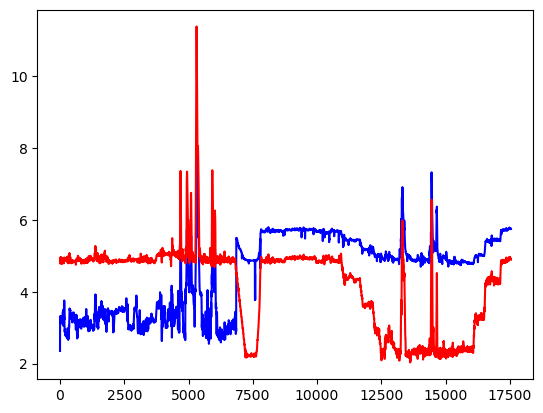

In [26]:
plt.plot(output_lst, color = 'b')
plt.plot(test_label_df.values, color = 'r')

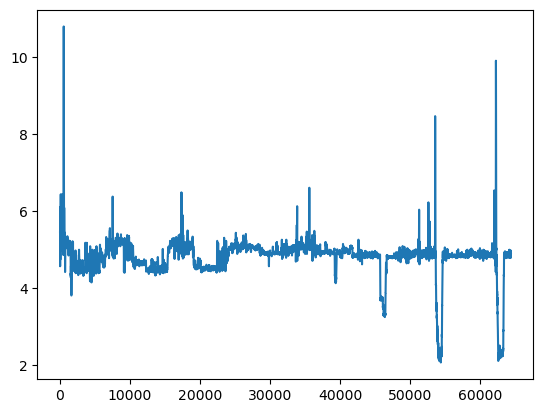

In [27]:
plt.plot(train_label_df)

# Reload model

In [28]:
import importlib
importlib.reload(model)

<module 'model' from '/home/khs1/khs/changwon/2022ChangWon_BigData/model.py'>